# Logistic Modeling of COVID-19 Confirmed Cases
I compared the accuracy of two sigmoid models: [simple logistic function](https://en.wikipedia.org/wiki/Logistic_function) and [Gompertz function](https://en.wikipedia.org/wiki/Gompertz_function), and found the Gompertz function to be a fairly accurate short-term predictor of future confirmed cases.

### Defining our parameters and loading the data
I looked at the confirmed and fatal cases for Korea through March 18 since Kenya had just reported its first case hence less data available.

In [38]:
ESTIMATE_DAYS = 3
data_key = 'KR'
date_limit = '2020-03-18'

In [39]:
import pandas as pd
import seaborn as sns
sns.set()

df = pd.read_csv(f'https://storage.googleapis.com/covid19-open-data/v2/{data_key}/main.csv').set_index('date')

### Looking at the outbreak
 *outbreak* is whenever the number of cases exceeded certain threshold. In this case, I used 10.

In [49]:
def get_outbreak_mask(data: pd.DataFrame, threshold: int = 10):
    ''' Returns a mask for > N confirmed cases '''
    return data['total_confirmed'] > threshold

In [41]:
cols = ['total_confirmed', 'total_deceased']
# Get data only for the columns we care about
df = df[cols]
# Get data only for the selected dates
df = df[df.index <= date_limit]
# Get data only after the outbreak begun
df = df[get_outbreak_mask(df)]

### Plotting the data


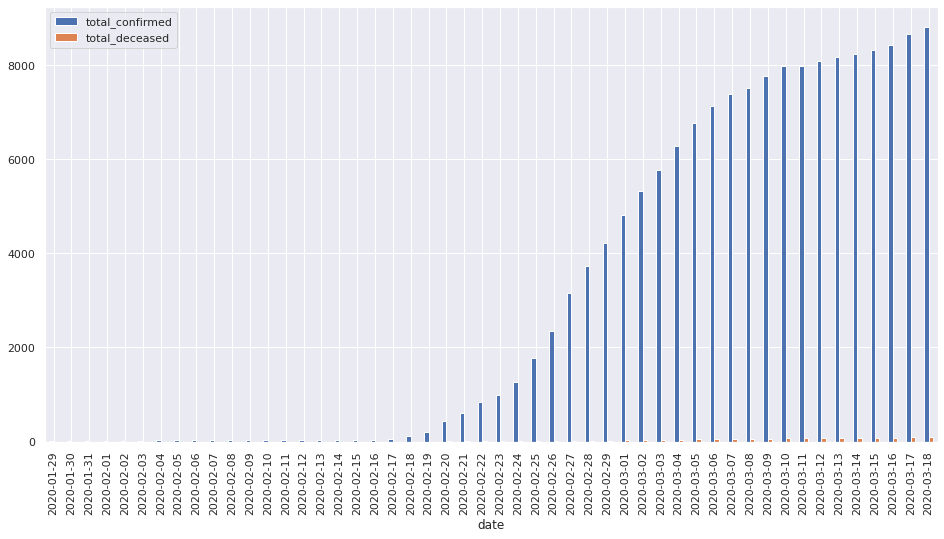

In [42]:
df.plot(kind='bar', figsize=(16, 8));

### Modeling the data
By the time the outbreak is discovered, there are many undiagnosed (and even asymptomatic) cases which lead to very rapid initial growth; later on, after a combination of aggressive measures to avoid further spread and immunity developed by potential hosts, the growth becomes much slower.

In [43]:
import math
import numpy as np
from scipy import optimize

def logistic_function(x: float, a: float, b: float, c: float):
    ''' 1 / (1 + e^-x) '''
    return a / (1.0 + np.exp(-b * (x - c)))

X, y = list(range(len(df))), df['total_confirmed'].tolist()
# Providing a reasonable initial guess is crucial for this model
params, _ = optimize.curve_fit(logistic_function, X, y, maxfev=int(1E5), p0=[max(y), 1, np.median(X)])

print('Estimated function: {0:.3f} / (1 + e^({1:.3f} * (X - {2:.3f}))'.format(*params))

Estimated function: 8433.513 / (1 + e^(0.299 * (X - 31.201))


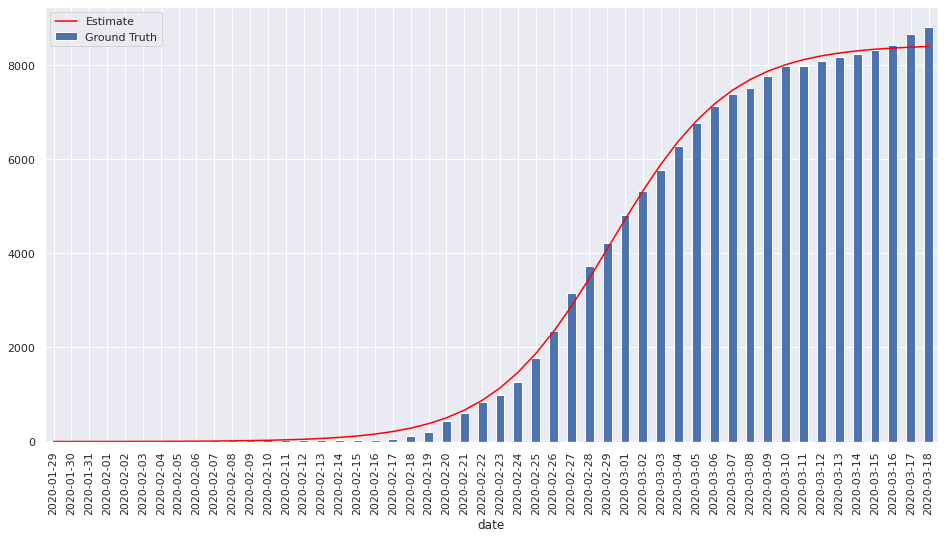

In [44]:
confirmed = df[['total_confirmed']].rename(columns={'total_confirmed': 'Ground Truth'})
ax = confirmed.plot(kind='bar', figsize=(16, 8))
estimate = [logistic_function(x, *params) for x in X]
ax.plot(df.index, estimate, color='red', label='Estimate')
ax.legend();

### Gompertz function
[Gompertz function](https://en.wikipedia.org/wiki/Gompertz_function) is an asymmetric logistic function that has a slower growth decay until the curve goes flat over time. Let's take a look at using this new function to find the best paremeters that fit the data:

In [45]:
def logistic_function(x: float, a: float, b: float, c: float):
    ''' a * e^(-b * e^(-cx)) '''
    return a * np.exp(-b * np.exp(-c * x))

X, y = list(range(len(df))), df['total_confirmed'].tolist()
# Providing a reasonable initial guess is crucial for this model
params, _ = optimize.curve_fit(logistic_function, X, y, maxfev=int(1E5), p0=[max(y), np.median(X), .1])

print('Estimated function: {0:.3f} * e^(-{1:.3f} * e^(-{2:.3f}X))'.format(*params))

Estimated function: 8845.794 * e^(-225.246 * e^(-0.185X))


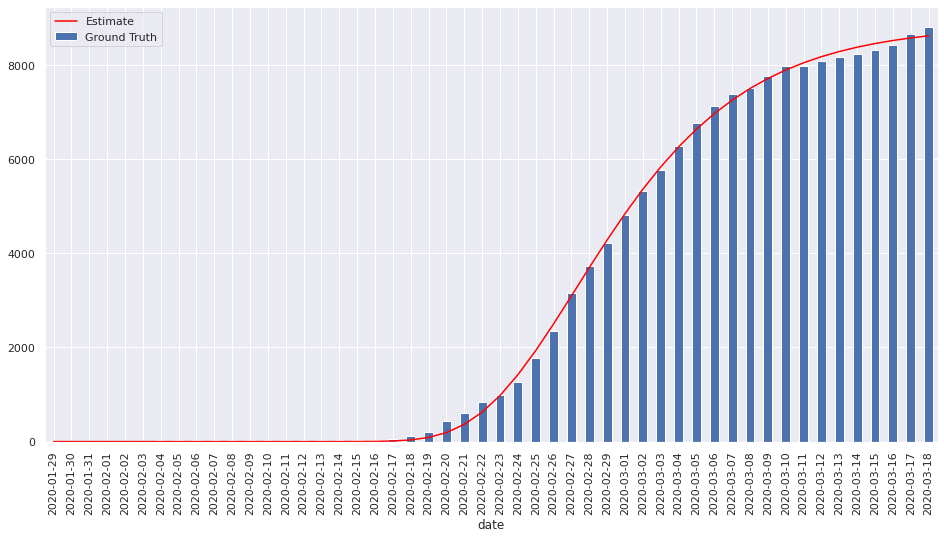

In [46]:
confirmed = df[['total_confirmed']].rename(columns={'total_confirmed': 'Ground Truth'})
ax = confirmed.plot(kind='bar', figsize=(16, 8))
estimate = [logistic_function(x, *params) for x in X]
ax.plot(df.index, estimate, color='red', label='Estimate')
ax.legend();

### Evaluating the model
That curve looks like a very good fit! 

*overfitting* occurs which diminishes the model's ability to make predictions. In other words, the model may appear to be able to perfectly follow known data, but when asked to make a prediction about future data it will likely be wrong. This is one of the main reasons why machine learning is not a good tool for this task, since there is not enough data to avoid overfitting a model.

### Validating the model
I fitted without looking at the last 3 days of data. Then, I estimated the missing days using our model, and verified if the results still hold by comparing what the model thought was going to happen with the actual data.

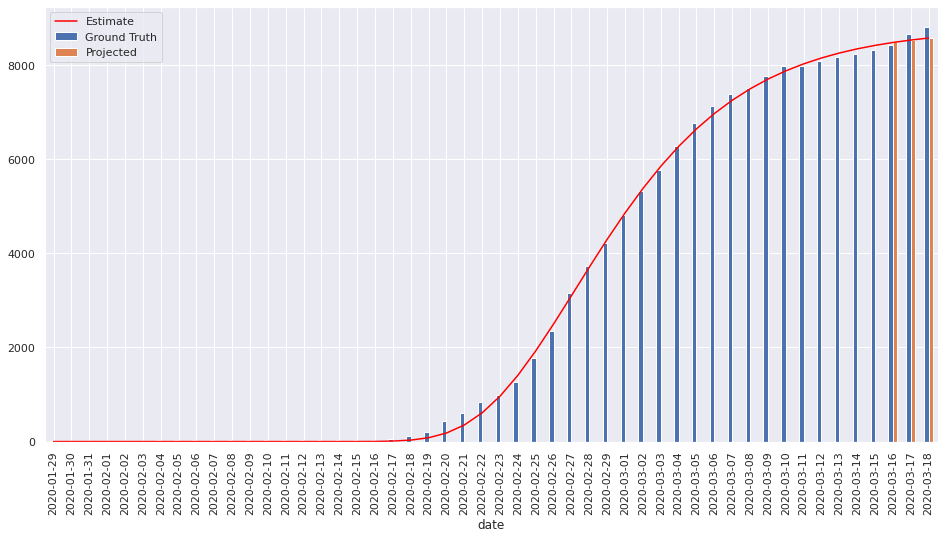

In [47]:
params_validate, _ = optimize.curve_fit(logistic_function, X[:-ESTIMATE_DAYS], y[:-ESTIMATE_DAYS])

# Project zero for all values except for the last ESTIMATE_DAYS
projected = [0] * len(X[:-ESTIMATE_DAYS]) + [logistic_function(x, *params_validate) for x in X[-ESTIMATE_DAYS:]]
projected = pd.Series(projected, index=df.index, name='Projected')
confirmed = pd.DataFrame({'Ground Truth': df['total_confirmed'], 'Projected': projected})
ax = confirmed.plot(kind='bar', figsize=(16, 8))
estimate = [logistic_function(x, *params_validate) for x in X]
ax.plot(df.index, estimate, color='red', label='Estimate')
ax.legend();

### Projecting future data
It looks like our logistic model slightly underestimates the confirmed cases. This indicates that the model is optimistic about the slowdown of new cases being reported. A number of factors could affect this, like wider availability of tests. 

Ultimately, it is also possible that the logistic model is not an appropriate function to use. However, the predictions are close enough to the real data that this is probably a good starting point for a rough estimate over a short time horizon.

Now, let's use the model we fitted earlier which used all the data, and try to predict what the next 3 days will look like.

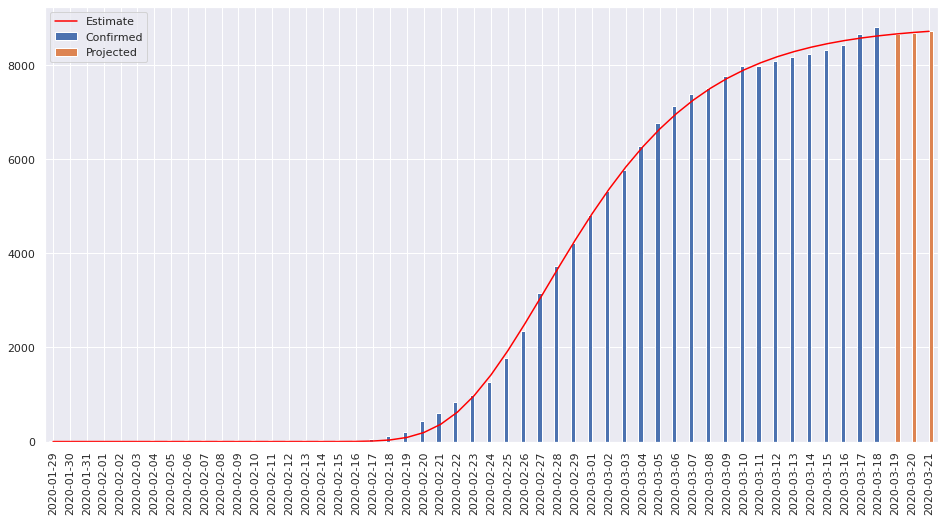

In [48]:
import datetime

# Append N new days to our indices
date_format = '%Y-%m-%d'
date_range = [datetime.datetime.strptime(date, date_format) for date in df.index]
for _ in range(ESTIMATE_DAYS): date_range.append(date_range[-1] + datetime.timedelta(days=1))
date_range = [datetime.datetime.strftime(date, date_format) for date in date_range]

# Perform projection with the previously estimated parameters
projected = [0] * len(X) + [logistic_function(x, *params) for x in range(len(X), len(X) + ESTIMATE_DAYS)]
projected = pd.Series(projected, index=date_range, name='Projected')
df_ = pd.DataFrame({'Confirmed': df['total_confirmed'], 'Projected': projected})
ax = df_.plot(kind='bar', figsize=(16, 8))
estimate = [logistic_function(x, *params) for x in range(len(date_range))]
ax.plot(date_range, estimate, color='red', label='Estimate')
ax.legend();